# **Klasifikasi Gerakan untuk Rehabilitasi Stroke Menggunakan LSTM**
Dataset yang akan digunakan adalah 10 video gerakan rehabilitasi untuk pasien stroke yang ditemukan di Internet.

Proyek ini bertujuan untuk mendeteksi gerakan ....

# **1. Import Library**

In [19]:
import os
import cv2
import pandas as pd
import numpy as np
import time
import seaborn as sns
import tensorflow as tf # Import TensorFlow
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict, deque
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from ultralytics import YOLO
from sklearn.preprocessing import StandardScaler # Import StandardScaler

# **2. Memuat Dataset**

In [20]:
# --- 2. Memuat Dataset ---
# Setup Folders for Collection
VIDEO_DIR = 'dataset_video' 
sequence_length = 30         # frame per sequence (akan di-resample ke sini)
# stride = sequence_length      # Variabel ini tidak digunakan di kode yang diperbarui
# augment_mirror    = True     # Variabel ini tidak digunakan di kode yang diperbarui
# test_video_idx  = -1         # Variabel ini tidak digunakan di kode yang diperbarui
RANDOM_SEED     = 42
# TRAIN_VIDS, TEST_VIDS = {}, {} # Variabel ini tidak digunakan di kode yang diperbarui

actions = sorted([d for d in os.listdir(VIDEO_DIR)
                  if os.path.isdir(os.path.join(VIDEO_DIR,d))])
print('Kelas terdeteksi:', actions, '\n')

vid_dict = defaultdict(list)   # {action: [video_path, …]}
for act in actions:
    for f in sorted(os.listdir(os.path.join(VIDEO_DIR,act))):
        if f.lower().endswith(('.mp4','.mov','.avi','.mkv')):\
            vid_dict[act].append(os.path.join(VIDEO_DIR,act,f))

Kelas terdeteksi: ['Angkat Pinggul', 'Angkat Tangan', 'Lutut Turun', 'Naikan Kepalan Kedepan', 'Rentangkan'] 



# **3. Exploratory Data Analysis (EDA)**

,action,video,fps,frames,duration
0,Angkat Pinggul,1.MOV,59.953704,259,4.320000
1,Angkat Pinggul,10.mp4,30.000000,104,3.466667
2,Angkat Pinggul,2.MOV,59.957326,281,4.686667
3,Angkat Pinggul,3.mp4,24.919779,146,5.858800
4,Angkat Pinggul,4.mp4,24.919583,149,5.979233
5,Angkat Pinggul,5.mp4,24.912027,202,8.108533
6,Angkat Pinggul,6.mp4,24.927840,114,4.573200
7,Angkat Pinggul,7.mp4,30.000000,139,4.633333
8,Angkat Pinggul,8.mp4,30.000000,157,5.233333
9,Angkat Pinggul,9.mp4,30.000000,145,4.833333


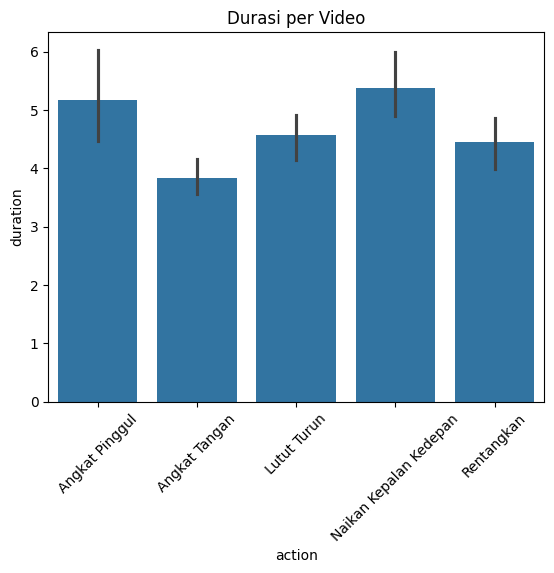

In [21]:
rows=[]
for act in actions:
    for vp in vid_dict[act]:
        cap=cv2.VideoCapture(vp)
        fps  = cap.get(cv2.CAP_PROP_FPS) or 30
        nfrm = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        dur  = nfrm/fps
        rows.append(dict(action=act, video=os.path.basename(vp),\
                         fps=fps, frames=nfrm, duration=dur))
        cap.release()
df=pd.DataFrame(rows)
display(df)
sns.barplot(data=df,x='action',y='duration')
plt.xticks(rotation=45); plt.title('Durasi per Video'); plt.show()

# **4. Preprocessing**

### Ekstraksi Keypoints


In [22]:
# --- 4. Preprocessing - Ekstraksi Keypoints ---
print("\n--- Ekstraksi Keypoints ---")
# ---------------------------\
# Inisialisasi Model YOLOv8
# ---------------------------\
# Pastikan path ke model YOLOv8n-pose.pt sudah benar
# Jika Anda menjalankan di Kaggle, mungkin perlu path absolut ke dataset input
pose_model = YOLO("yolov8n-pose.pt")  

# ---------------------------\
# Pengaturan Folder
# ---------------------------\
keypoint_root = "keypoints Rombak Preprocessing"    

# ---------------------------\
# Ekstraksi Keypoint
# ---------------------------\
if not os.path.exists(keypoint_root):
    os.makedirs(keypoint_root)

for action in actions:
    video_dir = os.path.join(VIDEO_DIR, action) # Menggunakan VIDEO_DIR dari atas
    save_dir = os.path.join(keypoint_root, action)
    os.makedirs(save_dir, exist_ok=True)

    for video_name in tqdm(os.listdir(video_dir), desc=f"Proses {action}"):
        video_path = os.path.join(video_dir, video_name)
        cap = cv2.VideoCapture(video_path)
        sequence = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # YOLOv8 akan secara internal me-resize frame untuk inference
            results = pose_model.predict(source=frame, conf=0.5, save=False, verbose=False)
            
            # Pastikan ada hasil deteksi dan keypoints
            # results[0] adalah objek Results dari Ultralytics
            if results and len(results[0].keypoints.xy) > 0:
                # Ambil keypoint orang pertama (xy format)
                # keypoints.xy[0] -> (17, 2) array of [x, y]
                kps = results[0].keypoints.xy[0].cpu().numpy()  
                
                # Pastikan 17 keypoints terdeteksi
                if kps.shape[0] == 17:  
                    # Dapatkan dimensi frame untuk normalisasi
                    h, w, _ = frame.shape
                    
                    # Normalisasi koordinat X dan Y ke rentang 0-1
                    # x_normalized = x / width, y_normalized = y / height
                    normalized_kps = kps / np.array([w, h])
                    
                    # Flatten keypoints (17, 2) menjadi (34,) = 17 keypoints × 2 (x, y)
                    sequence.append(normalized_kps.flatten())  
                else:
                    # Jika tidak ada 17 keypoint yang terdeteksi, tambahkan array nol (34 fitur)
                    sequence.append(np.zeros(17 * 2)) 
            else:
                # Jika tidak ada deteksi sama sekali, tambahkan array nol (34 fitur)
                sequence.append(np.zeros(17 * 2))

        cap.release()

        # Simpan hanya jika ada sequence valid
        if len(sequence) > 0:
            try:
                sequence = np.array(sequence)  # shape: (n_frames, 34)
                save_path = os.path.join(save_dir, video_name.replace(".MOV", ".npy").replace(".mp4", ".npy"))
                np.save(save_path, sequence)
                print(f"✅ Keypoint disimpan: {save_path}")
            except ValueError as e:
                print(f"❌ Gagal menyimpan {video_name}: {e}")
        else:
            print(f"⚠️ Tidak ada keypoint valid di {video_name}")


--- Ekstraksi Keypoints ---


Proses Angkat Pinggul:  10%|█         | 1/10 [00:11<01:43, 11.53s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\1.npy


Proses Angkat Pinggul:  20%|██        | 2/10 [00:16<01:00,  7.54s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\10.npy


Proses Angkat Pinggul:  30%|███       | 3/10 [00:28<01:08,  9.76s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\2.npy


Proses Angkat Pinggul:  40%|████      | 4/10 [00:34<00:49,  8.21s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\3.npy


Proses Angkat Pinggul:  50%|█████     | 5/10 [00:40<00:36,  7.36s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\4.npy


Proses Angkat Pinggul:  60%|██████    | 6/10 [00:48<00:30,  7.57s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\5.npy


Proses Angkat Pinggul:  70%|███████   | 7/10 [00:52<00:19,  6.58s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\6.npy


Proses Angkat Pinggul:  80%|████████  | 8/10 [00:58<00:12,  6.42s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\7.npy


Proses Angkat Pinggul:  90%|█████████ | 9/10 [01:05<00:06,  6.55s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\8.npy


Proses Angkat Pinggul: 100%|██████████| 10/10 [01:12<00:00,  7.21s/it]


✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\9.npy


Proses Angkat Tangan:  10%|█         | 1/10 [00:04<00:42,  4.75s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\1.npy


Proses Angkat Tangan:  20%|██        | 2/10 [00:09<00:37,  4.72s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\10.npy


Proses Angkat Tangan:  30%|███       | 3/10 [00:13<00:29,  4.27s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\2.npy


Proses Angkat Tangan:  40%|████      | 4/10 [00:19<00:29,  4.91s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\3.npy


Proses Angkat Tangan:  50%|█████     | 5/10 [00:22<00:22,  4.56s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\4.npy


Proses Angkat Tangan:  60%|██████    | 6/10 [00:27<00:18,  4.71s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\5.npy


Proses Angkat Tangan:  70%|███████   | 7/10 [00:33<00:14,  4.96s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\6.npy


Proses Angkat Tangan:  80%|████████  | 8/10 [00:38<00:09,  4.98s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\7.npy


Proses Angkat Tangan:  90%|█████████ | 9/10 [00:43<00:04,  4.84s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\8.npy


Proses Angkat Tangan: 100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\9.npy


Proses Lutut Turun:  10%|█         | 1/10 [00:12<01:50, 12.29s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\1.npy


Proses Lutut Turun:  20%|██        | 2/10 [00:16<00:58,  7.34s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\10.npy


Proses Lutut Turun:  30%|███       | 3/10 [00:28<01:06,  9.56s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\2.npy


Proses Lutut Turun:  40%|████      | 4/10 [00:33<00:46,  7.81s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\3.npy


Proses Lutut Turun:  50%|█████     | 5/10 [00:38<00:33,  6.77s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\4.npy


Proses Lutut Turun:  60%|██████    | 6/10 [00:43<00:24,  6.19s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\5.npy


Proses Lutut Turun:  70%|███████   | 7/10 [00:47<00:16,  5.49s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\6.npy


Proses Lutut Turun:  80%|████████  | 8/10 [00:54<00:11,  5.89s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\7.npy


Proses Lutut Turun:  90%|█████████ | 9/10 [01:01<00:06,  6.18s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\8.npy


Proses Lutut Turun: 100%|██████████| 10/10 [01:06<00:00,  6.68s/it]


✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\9.npy


Proses Naikan Kepalan Kedepan:  10%|█         | 1/10 [00:04<00:41,  4.56s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\1.npy


Proses Naikan Kepalan Kedepan:  20%|██        | 2/10 [00:11<00:46,  5.87s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\10.npy


Proses Naikan Kepalan Kedepan:  30%|███       | 3/10 [00:17<00:42,  6.05s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\2.npy


Proses Naikan Kepalan Kedepan:  40%|████      | 4/10 [00:22<00:34,  5.69s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\3.npy


Proses Naikan Kepalan Kedepan:  50%|█████     | 5/10 [00:29<00:29,  5.94s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\4.npy


Proses Naikan Kepalan Kedepan:  60%|██████    | 6/10 [00:41<00:32,  8.05s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\5.npy


Proses Naikan Kepalan Kedepan:  70%|███████   | 7/10 [00:53<00:28,  9.49s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\6.npy


Proses Naikan Kepalan Kedepan:  80%|████████  | 8/10 [01:03<00:18,  9.49s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\7.npy


Proses Naikan Kepalan Kedepan:  90%|█████████ | 9/10 [01:09<00:08,  8.42s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\8.npy


Proses Naikan Kepalan Kedepan: 100%|██████████| 10/10 [01:16<00:00,  7.68s/it]


✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\9.npy


Proses Rentangkan:  10%|█         | 1/10 [00:04<00:36,  4.04s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\1.npy


Proses Rentangkan:  20%|██        | 2/10 [00:10<00:45,  5.63s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\10.npy


Proses Rentangkan:  30%|███       | 3/10 [00:15<00:36,  5.27s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\2.npy


Proses Rentangkan:  40%|████      | 4/10 [00:19<00:28,  4.68s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\3.npy


Proses Rentangkan:  50%|█████     | 5/10 [00:24<00:24,  4.87s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\4.npy


Proses Rentangkan:  60%|██████    | 6/10 [00:31<00:22,  5.61s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\5.npy


Proses Rentangkan:  70%|███████   | 7/10 [00:40<00:20,  6.79s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\6.npy


Proses Rentangkan:  80%|████████  | 8/10 [00:47<00:13,  6.77s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\7.npy


Proses Rentangkan:  90%|█████████ | 9/10 [00:54<00:06,  6.79s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\8.npy


Proses Rentangkan: 100%|██████████| 10/10 [00:58<00:00,  5.89s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\9.npy


### Persiapan Dataset untuk Training


In [23]:
# --- 4. Preprocessing - Persiapan Dataset untuk Training ---
print("\n--- Persiapan Dataset untuk Training ---")
X, y, groups = [], [], []

# Loop untuk load semua data .npy
for idx, action in enumerate(actions):
    action_dir = os.path.join(keypoint_root, action)
    # Pastikan direktori aksi ada untuk menghindari error
    if not os.path.exists(action_dir):
        print(f"Direktori '{action_dir}' tidak ditemukan. Melewati aksi ini.")
        continue

    for file in os.listdir(action_dir):
        if file.endswith('.npy'):
            filepath = os.path.join(action_dir, file)
            seq = np.load(filepath)  # bentuk: (n_frames, n_features)
            
            desired_frames = 30 # Panjang sequence yang diinginkan
            
            # --- Menggunakan Resampling (np.linspace) ---
            original_n_frames = seq.shape[0]
            
            if original_n_frames == 0:
                # Jika tidak ada frame, buat array nol dengan shape yang sesuai (34 fitur)
                n_features = 17 * 2 # 17 keypoints * 2 koordinat (x,y)
                resampled_seq = np.zeros((desired_frames, n_features))
            else:
                # Buat indeks untuk resampling secara merata dari durasi asli
                indices = np.linspace(0, original_n_frames - 1, num=desired_frames, dtype=int)
                resampled_seq = seq[indices]
            
            X.append(resampled_seq)
            y.append(idx)  # label encoded numerik
            
            # Mengambil group ID dari nama file (misal: '1.npy' -> '1')
            # Sesuaikan jika format file Anda berbeda (misal: 'videoID_action.npy' -> file.split('_')[0])
            groups.append(os.path.basename(file).split('.')[0]) 

X = np.array(X)  # shape (N_samples, timesteps, features)
y = np.array(y)
groups = np.array(groups)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)
print("Groups shape:", groups.shape)


--- Persiapan Dataset untuk Training ---
Data shape: (50, 30, 34)
Labels shape: (50,)
Groups shape: (50,)


### Split Data

In [24]:
# --- 4. Preprocessing - Split Data dan Augmentasi Data ---
print("\n--- Split Data dan Augmentasi Data ---")
# Fungsi augmentasi: tambahkan noise Gaussian pada keypoint
def augment_data(X_data, noise_level=0.01):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X_data.shape)
    X_aug = X_data + noise
    return X_aug

RANDOM_SEED = 42
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

train_idx, val_idx = next(gss.split(X, y, groups))

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

print("Train shape (sebelum augmentasi):", X_train.shape)
print("Validation shape:", X_val.shape)

# Augmentasi hanya di data train
X_train_aug = augment_data(X_train, noise_level=0.005) # Level noise bisa disesuaikan

# One-hot encode label
num_classes = len(actions)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

print("X_train_aug shape:", X_train_aug.shape)
print("y_train_one_hot shape:", y_train_one_hot.shape)


--- Split Data dan Augmentasi Data ---
Train shape (sebelum augmentasi): (40, 30, 34)
Validation shape: (10, 30, 34)
X_train_aug shape: (40, 30, 34)
y_train_one_hot shape: (40, 5)


# **5. Pembangunan Model**

## **a. Pelatihan Model**

In [25]:
# --- 5. Pembangunan dan Pelatihan Model ---
print("\n--- Pembangunan dan Pelatihan Model ---")

# Inisialisasi StandardScaler (akan di-fit pada data training)
# Ini akan digunakan untuk semua model (LSTM, GRU, CNN)
scaler = StandardScaler()

# Ambil nilai shape input dari X_train_aug
sequence_length = X_train_aug.shape[1]  # 30
num_features = X_train_aug.shape[2]     # 34 (17 keypoints * 2 koordinat x,y)

# Flatten data agar bisa di-scaler, lalu reshape kembali
X_train_flat = X_train_aug.reshape(-1, num_features)
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(-1, sequence_length, num_features)

X_val_flat = X_val.reshape(-1, num_features)
X_val_scaled = scaler.transform(X_val_flat).reshape(-1, sequence_length, num_features)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)


--- Pembangunan dan Pelatihan Model ---
X_train_scaled shape: (40, 30, 34)
X_val_scaled shape: (10, 30, 34)


In [26]:
# --- Model LSTM ---
print("\n--- Melatih Model LSTM ---")
model_lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(sequence_length, num_features)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

callbacks_lstm = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ModelCheckpoint('model rombak preprocessing/lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
]

history_lstm = model_lstm.fit(
    X_train_scaled, y_train_one_hot,
    validation_data=(X_val_scaled, y_val_one_hot), # Gunakan X_val_scaled
    epochs=200,
    batch_size=8, 
    shuffle=True,
    callbacks=callbacks_lstm,
    verbose=2
)



--- Melatih Model LSTM ---
Epoch 1/200


c:\Users\M Fathurrahman\Videos\LASKAR AI\ActionDetection-Yolo--2-\coba\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 1.68184, saving model to model rombak preprocessing/lstm_best.keras
5/5 - 1s - 260ms/step - categorical_accuracy: 0.2000 - loss: 1.7042 - val_categorical_accuracy: 0.3000 - val_loss: 1.6818 - learning_rate: 1.0000e-04
Epoch 2/200

Epoch 2: val_loss improved from 1.68184 to 1.65415, saving model to model rombak preprocessing/lstm_best.keras
5/5 - 0s - 22ms/step - categorical_accuracy: 0.1750 - loss: 1.7499 - val_categorical_accuracy: 0.3000 - val_loss: 1.6541 - learning_rate: 1.0000e-04
Epoch 3/200

Epoch 3: val_loss improved from 1.65415 to 1.62768, saving model to model rombak preprocessing/lstm_best.keras
5/5 - 0s - 22ms/step - categorical_accuracy: 0.1500 - loss: 1.5709 - val_categorical_accuracy: 0.3000 - val_loss: 1.6277 - learning_rate: 1.0000e-04
Epoch 4/200

Epoch 4: val_loss improved from 1.62768 to 1.60318, saving model to model rombak preprocessing/lstm_best.keras
5/5 - 0s - 22ms/step - categorical_accuracy: 0.2750 - loss: 1.6770 - val

## GRU

In [27]:
# --- Model GRU ---
print("\n--- Melatih Model GRU ---")
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(sequence_length, num_features)),
    BatchNormalization(),
    Dropout(0.4),
    GRU(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.4),
    GRU(64),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_gru.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

callbacks_gru = [
    EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss', verbose=1),
    ModelCheckpoint('model rombak preprocessing/gru_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=1, min_lr=1e-6)
]

history_gru = model_gru.fit(
    X_train_scaled, y_train_one_hot, # Gunakan X_train_scaled
    epochs=150,
    batch_size=16,
    validation_data=(X_val_scaled, y_val_one_hot), # Gunakan X_val_scaled
    callbacks=callbacks_gru,
    verbose=2
)


--- Melatih Model GRU ---
Epoch 1/150

Epoch 1: val_loss improved from inf to 1.44493, saving model to model rombak preprocessing/gru_best.keras
3/3 - 5s - 2s/step - categorical_accuracy: 0.2500 - loss: 2.3159 - val_categorical_accuracy: 0.6000 - val_loss: 1.4449 - learning_rate: 1.0000e-04
Epoch 2/150

Epoch 2: val_loss improved from 1.44493 to 1.42047, saving model to model rombak preprocessing/gru_best.keras
3/3 - 0s - 59ms/step - categorical_accuracy: 0.3500 - loss: 2.0917 - val_categorical_accuracy: 0.6000 - val_loss: 1.4205 - learning_rate: 1.0000e-04
Epoch 3/150

Epoch 3: val_loss improved from 1.42047 to 1.39495, saving model to model rombak preprocessing/gru_best.keras
3/3 - 0s - 60ms/step - categorical_accuracy: 0.4000 - loss: 2.0019 - val_categorical_accuracy: 0.6000 - val_loss: 1.3949 - learning_rate: 1.0000e-04
Epoch 4/150

Epoch 4: val_loss improved from 1.39495 to 1.36808, saving model to model rombak preprocessing/gru_best.keras
3/3 - 0s - 59ms/step - categorical_accur

In [28]:
# --- Model 1D CNN ---
print("\n--- Melatih Model 1D CNN ---")
model_cnn = Sequential([
    Conv1D(128, kernel_size=5, activation='relu', input_shape=(sequence_length, num_features), padding='same'),
    BatchNormalization(), 
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(), 
    Dropout(0.3),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    BatchNormalization(), 
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

callbacks_cnn = [
    EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss', verbose=1),
    ModelCheckpoint('model rombak preprocessing/cnn_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=1, min_lr=1e-6)
]

history_cnn = model_cnn.fit(
    X_train_scaled, y_train_one_hot,
    epochs=150,
    batch_size=16,
    validation_data=(X_val_scaled, y_val_one_hot),
    callbacks=callbacks_cnn,
    verbose=2
)


--- Melatih Model 1D CNN ---
Epoch 1/150


c:\Users\M Fathurrahman\Videos\LASKAR AI\ActionDetection-Yolo--2-\coba\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_loss improved from inf to 1.72911, saving model to model rombak preprocessing/cnn_best.keras
3/3 - 2s - 609ms/step - categorical_accuracy: 0.1250 - loss: 2.6858 - val_categorical_accuracy: 0.2000 - val_loss: 1.7291 - learning_rate: 1.0000e-04
Epoch 2/150

Epoch 2: val_loss improved from 1.72911 to 1.66776, saving model to model rombak preprocessing/cnn_best.keras
3/3 - 0s - 42ms/step - categorical_accuracy: 0.3000 - loss: 2.0887 - val_categorical_accuracy: 0.4000 - val_loss: 1.6678 - learning_rate: 1.0000e-04
Epoch 3/150

Epoch 3: val_loss improved from 1.66776 to 1.60374, saving model to model rombak preprocessing/cnn_best.keras
3/3 - 0s - 42ms/step - categorical_accuracy: 0.2250 - loss: 1.9447 - val_categorical_accuracy: 0.4000 - val_loss: 1.6037 - learning_rate: 1.0000e-04
Epoch 4/150

Epoch 4: val_loss improved from 1.60374 to 1.54321, saving model to model rombak preprocessing/cnn_best.keras
3/3 - 0s - 43ms/step - categorical_accuracy: 0.6000 - loss: 1.2593 - val_cat

# Grafik


--- Plotting Hasil Pelatihan ---


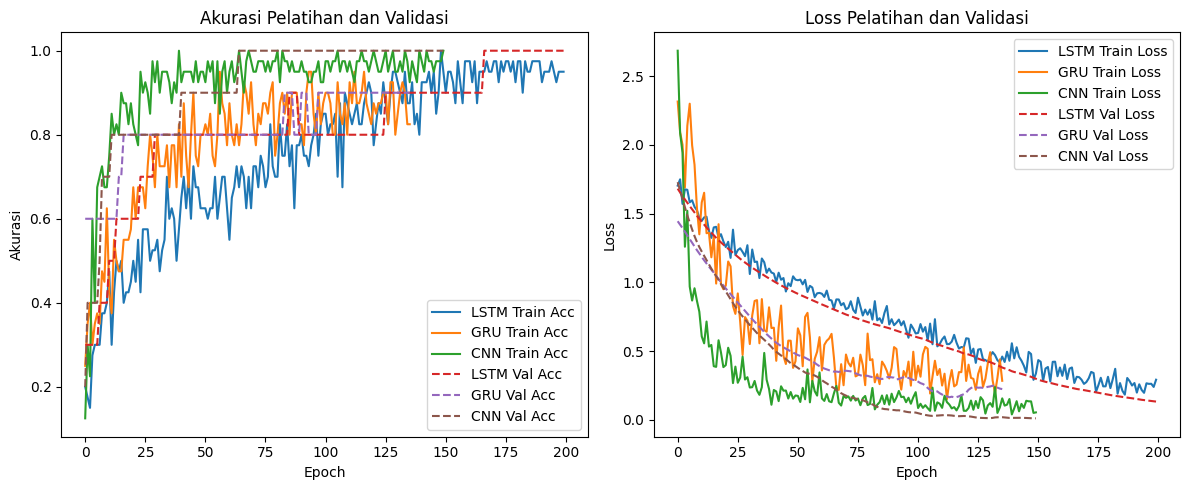

In [29]:
# --- 5. Pembangunan dan Pelatihan Model - Plot Hasil ---
print("\n--- Plotting Hasil Pelatihan ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['categorical_accuracy'], label='LSTM Train Acc')
plt.plot(history_gru.history['categorical_accuracy'], label='GRU Train Acc')
plt.plot(history_cnn.history['categorical_accuracy'], label='CNN Train Acc')
plt.plot(history_lstm.history['val_categorical_accuracy'], label='LSTM Val Acc', linestyle='--')
plt.plot(history_gru.history['val_categorical_accuracy'], label='GRU Val Acc', linestyle='--')
plt.plot(history_cnn.history['val_categorical_accuracy'], label='CNN Val Acc', linestyle='--')
plt.title("Akurasi Pelatihan dan Validasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_gru.history['loss'], label='GRU Train Loss')
plt.plot(history_cnn.history['loss'], label='CNN Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss', linestyle='--')
plt.plot(history_gru.history['val_loss'], label='GRU Val Loss', linestyle='--')
plt.plot(history_cnn.history['val_loss'], label='CNN Val Loss', linestyle='--')
plt.title("Loss Pelatihan dan Validasi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

## **b. Evaluasi Model**


--- Evaluasi Performa Model di Validation Set ---

=== Validation Performance ===


,acc,prec,rec,f1
model,,,,
LSTM,1.0,1.0,1.0,1.000
GRU,0.8,0.7,0.8,0.733
CNN,1.0,1.0,1.0,1.000



--- Classification Report untuk Model Terbaik (LSTM) ---
                        precision    recall  f1-score   support

        Angkat Pinggul       1.00      1.00      1.00         2
         Angkat Tangan       1.00      1.00      1.00         2
           Lutut Turun       1.00      1.00      1.00         2
Naikan Kepalan Kedepan       1.00      1.00      1.00         2
            Rentangkan       1.00      1.00      1.00         2

              accuracy                           1.00        10
             macro avg       1.00      1.00      1.00        10
          weighted avg       1.00      1.00      1.00        10



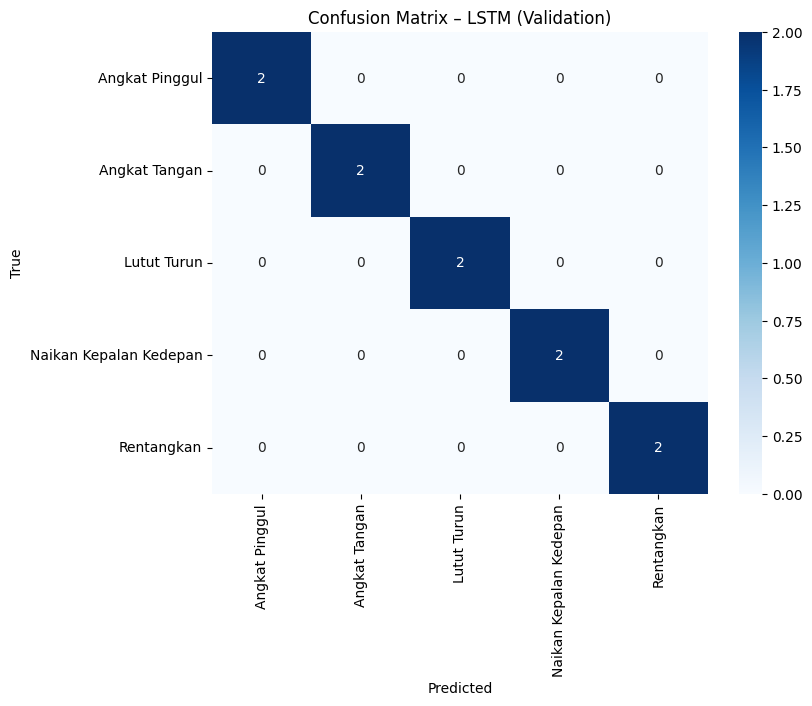

In [30]:
# --- 6. Evaluasi Model ---
print("\n--- Evaluasi Performa Model di Validation Set ---")
def eval_val(model, X_data_scaled, y_true_one_hot): # Menerima data yang sudah di-scaled
    y_prob = model.predict(X_data_scaled, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_true_one_hot, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    return acc, prec, rec, f1, y_true, y_pred

models_to_eval = {
    'LSTM': {'path': 'lstm_best.keras', 'data_scaled': X_val_scaled},
    'GRU': {'path': 'gru_best.keras', 'data_scaled': X_val_scaled},
    'CNN': {'path': 'cnn_best.keras', 'data_scaled': X_val_scaled}
}

scores = []
for name, config in models_to_eval.items():
    m = load_model(config['path'])
    acc, prec, rec, f1, _, _ = eval_val(m, config['data_scaled'], y_val_one_hot)
    scores.append(dict(model=name, acc=acc, prec=prec, rec=rec, f1=f1))

perf = pd.DataFrame(scores).set_index('model').round(3)
print('\n=== Validation Performance ===')
display(perf)

best_model_name = perf['f1'].idxmax()
best_model = load_model(models_to_eval[best_model_name]['path'])
acc, prec, rec, f1, y_true_val, y_pred_val = eval_val(best_model, models_to_eval[best_model_name]['data_scaled'], y_val_one_hot)

print(f"\n--- Classification Report untuk Model Terbaik ({best_model_name}) ---")
print(classification_report(y_true_val, y_pred_val, target_names=actions, zero_division=0))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true_val, y_pred_val, labels=range(num_classes))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=actions, yticklabels=actions, cmap='Blues')
plt.title(f'Confusion Matrix – {best_model_name} (Validation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Kompres folder 'keypoints' menjadi 'keypoints.zip' jika belum ada
import shutil
if not os.path.exists('keypoints.zip'):
    shutil.make_archive('keypoints', 'zip', 'keypoints')
    print("\nFolder keypoints telah dikompres menjadi keypoints.zip")

In [31]:
import shutil

# Kompres folder 'keypoint' jadi 'keypoint.zip' di direktori kerja
shutil.make_archive('/kaggle/working/keypoints', 'zip', '/kaggle/working/keypoints')


'c:\\kaggle\\working\\keypoints.zip'

# **6. Inferensi Model**

## **a. Inferensi Klasifikasi Gerakan**

In [ ]:
# --- 7. Inferensi Model - a. Inferensi Klasifikasi Gerakan ---
print("\n--- Inferensi Model - Klasifikasi Gerakan ---")

# ------------ Parameter ---------------\
SEQ_LEN       = 30 # Harus sama dengan SEQ_LEN saat training
DETECT_THRESH = 0.7 # Ambang batas keyakinan deteksi (bisa disesuaikan)
# LABELS = np.array(['Angkat Pinggul', 'Kaki Kebelakang', 'Lutut Turun', 'Naikan Kepalan Kedepan', 'Rentangkan'])
# Gunakan array ACTIONS yang sudah didefinisikan di awal notebook
LABELS = np.array(actions)

# ------------ Load model ---------------\
# Asumsi model terbaik yang akan digunakan untuk inferensi
inference_model = load_model(models_to_eval[best_model_name]['path']) 
pose_model = YOLO('yolov8n-pose.pt') # YOLOv8 pose model

# ------------ Buffer sequence -----------\
buf = deque(maxlen=SEQ_LEN)

cap = cv2.VideoCapture(0) # Menggunakan webcam (0)

# --- Fungsi Ekstraksi Keypoints untuk Inferensi (Konsisten dengan Training) ---
def extract_and_normalize_keypoints_inference(results, frame_shape):
    num_kpts_features = 17 * 2 # Hanya x,y koordinat
    
    # Inisialisasi keypoints_flat dengan nol jika tidak ada deteksi
    keypoints_flat = np.zeros(num_kpts_features, dtype='float32')

    if results is not None and len(results.keypoints.xy) > 0:
        # Ambil keypoint orang pertama (xy format)
        kps = results.keypoints.xy[0].cpu().numpy()  # (17, 2) array of [x, y]
        
        if kps.shape[0] == 17: # pastikan 17 keypoints
            h, w, _ = frame_shape
            # Normalisasi koordinat X dan Y ke rentang 0-1
            normalized_kps = kps / np.array([w, h])
            keypoints_flat = normalized_kps.flatten()
    
    return keypoints_flat.astype('float32')

print("Memulai inferensi klasifikasi gerakan. Tekan 'ESC' untuk keluar.")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # ------------ YOLO Pose Estimation -------------\
    results_yolo = pose_model.predict(frame, verbose=False)
    
    # Ekstrak dan normalisasi keypoints (34 fitur)
    keypoints_current_frame = extract_and_normalize_keypoints_inference(results_yolo[0], frame.shape)
    buf.append(keypoints_current_frame)

    # Lakukan inferensi hanya jika buffer sudah penuh
    pred_label = "Menunggu Gerakan..."
    last_conf = 0.0

    if len(buf) == SEQ_LEN:
        # Konversi buffer ke numpy array dan reshape untuk input model
        seq_input = np.array(buf).reshape(1, SEQ_LEN, num_kpts_features)
        
        # --- Terapkan StandardScaler (sama seperti saat training) ---
        # scaler_inference = scaler # Gunakan scaler yang sudah di-fit saat training
        seq_input_flat = seq_input.reshape(-1, num_kpts_features)
        seq_input_scaled = scaler.transform(seq_input_flat).reshape(1, SEQ_LEN, num_kpts_features)
        
        # Lakukan prediksi menggunakan model klasifikasi
        probs = inference_model.predict(seq_input_scaled, verbose=0)[0] 
        idx_pred = int(np.argmax(probs))
        last_conf = float(probs[idx_pred])
        pred_label = LABELS[idx_pred]

        # Filter prediksi dengan confidence rendah
        if last_conf < DETECT_THRESH:
            pred_label = "Tidak Yakin"

    # ---------- Tampilkan Hasil Inferensi di Frame ----------
    text = f"Pose: {pred_label} ({last_conf*100:.1f}%)"
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0) if last_conf > DETECT_THRESH else (0, 0, 255), 2)

    # ---------- Gambar Keypoints (untuk visualisasi) ----------
    # Gunakan keypoints dari hasil YOLO mentah untuk menggambar
    if results_yolo[0].keypoints is not None and len(results_yolo[0].keypoints.xy) > 0:
        annotated_frame = results_yolo[0].plot() # YOLOv8 plot() sudah menggambar keypoints
        cv2.imshow('YOLOv8 Pose + Model Klasifikasi', annotated_frame)
    else:
        cv2.imshow('YOLOv8 Pose + Model Klasifikasi', frame) # Tampilkan frame asli jika tidak ada deteksi

    if cv2.waitKey(1) & 0xFF == 27: # ESC keluar
        break

cap.release()
cv2.destroyAllWindows()


0: 480x640 (no detections), 50.9ms
Speed: 2.2ms preprocess, 50.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 40.3ms
Speed: 1.4ms preprocess, 40.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 40.3ms
Speed: 1.2ms preprocess, 40.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 42.9ms
Speed: 0.8ms preprocess, 42.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 41.8ms
Speed: 0.8ms preprocess, 41.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 41.5ms
Speed: 0.7ms preprocess, 41.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 40.6ms
Speed: 0.8ms preprocess, 40.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 40.2ms
Speed: 1.3ms preprocess, 40.2ms i

ValueError: Exception encountered when calling GRUCell.call().

[1mDimensions must be equal, but are 0 and 34 for '{{node sequential_1_1/gru_1/gru_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1_1/gru_1/strided_slice_1, sequential_1_1/gru_1/gru_cell_1/Cast/ReadVariableOp)' with input shapes: [1,0], [34,384].[0m

Arguments received by GRUCell.call():
  • inputs=tf.Tensor(shape=(1, 0), dtype=float32)
  • states=('tf.Tensor(shape=(1, 128), dtype=float32)',)
  • training=False

: 

## **b. Inferensi Lanjutan**

In [ ]:
# --- 7. Inferensi Model - b. Inferensi Lanjutan (Asisten Rehabilitasi) ---
print("\n--- Inferensi Model - Asisten Rehabilitasi ---")

# ---------- LABEL TETAP (sesuai training) ----------
# Gunakan array ACTIONS yang sudah didefinisikan di awal notebook
LABELS_WORKFLOW = np.array(actions)

# ---------- URUTAN LATIHAN (bebas diubah) ----------
WORKFLOW = np.array(['Angkat Tangan', 'Naikan Kepalan Kedepan', 'Rentangkan', 'Lutut Turun', 'Angkat Pinggul'])

# ---------- PARAMETER LAIN ----------
SEQ_LEN = 30 # Harus sama dengan SEQ_LEN saat training
DETECT_THRESH_MAIN_MODEL = 0.70 # Ambang batas keyakinan deteksi dari model utama

# Ambang batas progres untuk feedback (dalam rentang 0.0 - 1.0)
THRESHOLD_PARTIAL = 0.30  # Gerakan tidak sempurna (misal, 30% progres)
THRESHOLD_GOOD = 0.70     # Gerakan sempurna (misal, 70% progres)

# Durasi konfirmasi state (dalam jumlah frame)
CONFIRMATION_FRAMES_COMPLETE = 10 # Jika gerakan 'Sempurna' terdeteksi selama X frame berturut-turut
INACTIVITY_FRAMES_RESET = 30 # Jika tidak ada deteksi solid selama X frame, reset state

FONT = cv2.FONT_HERSHEY_SIMPLEX

# --- Load model (model terbaik dari training) ---
inference_model_workflow = load_model(models_to_eval[best_model_name]['path']) 
pose_model_workflow = YOLO('yolov8n-pose.pt') # YOLOv8 pose model

# --- Fungsi untuk Menghitung Progres Gerakan (HARUS DISESUAIKAN) ---
def calculate_movement_progress(current_kps_normalized, action_name, calibration_params):
    # current_kps_normalized: numpy array (17, 2) keypoint yang sudah dinormalisasi [0,1].
    # calibration_params: Dictionary parameter kalibrasi untuk setiap gerakan.
    
    progress = 0.0

    if action_name == "Angkat Tangan":
        # Keypoints: kp_9 (pergelangan kiri), kp_10 (pergelangan kanan)
        wrist_y_avg = (current_kps_normalized[9][1] + current_kps_normalized[10][1]) / 2
        min_y = calibration_params.get('min_y_wrist_at_100', 0.1) 
        max_y = calibration_params.get('max_y_wrist_at_0', 0.7)   
        if (max_y - min_y) > 0:
            progress = (max_y - wrist_y_avg) / (max_y - min_y)
        else:
            progress = 0.0

    elif action_name == "Angkat Pinggul":
        # Keypoints: kp_11 (pinggul kiri), kp_12 (pinggul kanan)
        hip_y_avg = (current_kps_normalized[11][1] + current_kps_normalized[12][1]) / 2
        min_y = calibration_params.get('min_y_hip_at_100', 0.6) 
        max_y = calibration_params.get('max_y_hip_at_0', 0.8)   
        if (max_y - min_y) > 0:
            progress = (max_y - hip_y_avg) / (max_y - min_y)
        else:
            progress = 0.0
            
    elif action_name == "Rentangkan":
        # Keypoints: kp_5 (bahu kiri), kp_6 (bahu kanan), kp_9 (pergelangan kiri), kp_10 (pergelangan kanan)
        hip_x_avg = (current_kps_normalized[11][0] + current_kps_normalized[12][0]) / 2
        dist_right_arm_x = current_kps_normalized[10][0] - hip_x_avg
        dist_left_arm_x = hip_x_avg - current_kps_normalized[9][0]
        max_abs_dist_x = max(dist_right_arm_x, dist_left_arm_x)

        min_x = calibration_params.get('min_x_stretch_observed', 0.05)
        max_x = calibration_params.get('max_x_stretch_observed', 0.35)
        
        if (max_x - min_x) > 0:
            progress = (max_abs_dist_x - min_x) / (max_x - min_x)
        else:
            progress = 0.0

    return np.clip(progress, 0.0, 1.0)

# --- Parameter Kalibrasi Gerakan (PENTING: Sesuaikan Ini!) ---
# Anda harus mengisi nilai-nilai ini berdasarkan analisis data training Anda.
# Lakukan EDA untuk setiap gerakan untuk menemukan rentang [0,1] yang sesuai.
CALIBRATION_PARAMS = {
    "Angkat Tangan": {
        'min_y_wrist_at_100': 0.1, # Y pergelangan tangan saat 100% terentang ke atas
        'max_y_wrist_at_0': 0.7    # Y pergelangan tangan saat 0% terentang (tangan di samping tubuh)
    },
    "Angkat Pinggul": {
        'min_y_hip_at_100': 0.6,   # Y pinggul saat 100% terangkat
        'max_y_hip_at_0': 0.8      # Y pinggul saat 0% terangkat (posisi awal)
    },
    "Rentangkan": {
        'min_x_stretch_observed': 0.05, # Jarak X minimal saat tangan di samping
        'max_x_stretch_observed': 0.35  # Jarak X maksimal saat tangan terentang penuh
    },
    # Tambahkan kalibrasi untuk gerakan lainnya
    "Lutut Turun": {}, # Placeholder
    "Naikan Kepalan Kedepan": {} # Placeholder
}

# --- Inisialisasi State Machine ---
current_main_action = "Idle" 
current_progress_stage = "Menunggu Gerakan..." 
main_action_counter = 0 
progress_stage_counter = 0 
frames_since_last_detection = 0 
keypoint_sequence_buffer_workflow = deque(maxlen=SEQ_LEN) # Buffer terpisah untuk workflow

idx_workflow_step = 0 # Melacak langkah workflow saat ini
t_ex_start = time.time() # Timer untuk durasi latihan
popup_phase = None # None | 'result' | 'prep'
popup_start = None
score_workflow = {w: None for w in WORKFLOW} # Skor untuk setiap langkah workflow

print("Memulai Asisten Rehabilitasi. Tekan 'ESC' untuk keluar.")
cap = cv2.VideoCapture(0) # Menggunakan webcam (0)

while cap.isOpened() and idx_workflow_step < len(WORKFLOW):
    ok, frame = cap.read()
    if not ok:
        break

    # ------------ YOLO Pose Estimation -------------\
    results_yolo = pose_model_workflow.predict(frame, verbose=False)
    bgr = frame.copy() # Salinan frame untuk menggambar keypoint dan HUD

    # Ekstrak dan normalisasi keypoints (34 fitur)
    keypoints_current_frame = extract_and_normalize_keypoints_inference(results_yolo[0], frame.shape)
    keypoint_sequence_buffer_workflow.append(keypoints_current_frame)

    # Lakukan inferensi model utama hanya jika buffer sudah penuh dan tidak ada popup
    predicted_action_from_model = "None"
    prediction_confidence = 0.0
    
    if len(keypoint_sequence_buffer_workflow) == SEQ_LEN and popup_phase is None:
        seq_input = np.array(keypoint_sequence_buffer_workflow).reshape(1, SEQ_LEN, keypoints_current_frame.shape[0])
        
        # Terapkan StandardScaler (sama seperti saat training)
        seq_input_flat = seq_input.reshape(-1, keypoints_current_frame.shape[0])
        seq_input_scaled = scaler.transform(seq_input_flat).reshape(1, SEQ_LEN, keypoints_current_frame.shape[0])
        
        prediction_probs = inference_model_workflow.predict(seq_input_scaled, verbose=0)
        predicted_action_idx = np.argmax(prediction_probs)
        prediction_confidence = np.max(prediction_probs)
        
        if prediction_confidence >= DETECT_THRESH_MAIN_MODEL:
            predicted_action_from_model = LABELS_WORKFLOW[predicted_action_idx]

    # --- Logika State Machine ---
    pop_up_message = ""
    target_action = WORKFLOW[idx_workflow_step] # Gerakan target saat ini

    if popup_phase is None: # Hanya proses state machine jika tidak ada popup
        
        # Cek durasi latihan
        remaining_time = EXER_TIME - int(time.time() - t_ex_start)
        if remaining_time <= 0:
            pop_up_message = f"*** POP-UP: Gerakan '{target_action}' Gagal (Waktu Habis)! ***"
            score_workflow[target_action] = False
            popup_phase = 'result'
            remaining_time = 0 # Pastikan tidak negatif

        elif predicted_action_from_model == target_action:
            frames_since_last_detection = 0 # Reset counter karena ada deteksi solid
            
            if current_main_action == "Idle" or current_main_action != target_action:
                current_main_action = target_action
                current_progress_stage = "Tidak Bergerak" # Default awal
                progress_stage_counter = 0
                main_action_counter = 0 
                pop_up_message = f"Mendeteksi Gerakan: '{current_main_action}'"

            elif predicted_action_from_model == current_main_action:
                main_action_counter += 1 
                
                # Hitung progres gerakan spesifik
                progress_value = calculate_movement_progress(keypoints_current_frame, current_main_action, CALIBRATION_PARAMS.get(current_main_action, {}))

                # --- Transisi Tahap Progres ---
                if progress_value >= THRESHOLD_GOOD:
                    if current_progress_stage != "Sempurna":
                        current_progress_stage = "Sempurna"
                        progress_stage_counter = 0 
                    progress_stage_counter += 1 
                    pop_up_message = f"'{current_main_action}': Gerakan Sempurna ({int(progress_value*100)}%)"

                elif progress_value >= THRESHOLD_PARTIAL:
                    if current_progress_stage != "Tidak Sempurna":
                        current_progress_stage = "Tidak Sempurna"
                        progress_stage_counter = 0 
                    progress_stage_counter += 1
                    pop_up_message = f"'{current_main_action}': Gerakan Tidak Sempurna ({int(progress_value*100)}%)"

                else: 
                    if current_progress_stage != "Tidak Bergerak":
                        current_progress_stage = "Tidak Bergerak"
                        progress_stage_counter = 0 
                    progress_stage_counter += 1
                    pop_up_message = f"'{current_main_action}': Gerakan Tidak Bergerak ({int(progress_value*100)}%)"

                # --- Cek Penyelesaian Gerakan (Sempurna) ---
                if current_progress_stage == "Sempurna" and progress_stage_counter >= CONFIRMATION_FRAMES_COMPLETE:
                    pop_up_message = f"*** POP-UP: Gerakan '{current_main_action}' Berhasil Diselesaikan dengan Sempurna! ***"
                    score_workflow[current_main_action] = True
                    popup_phase = 'result' # Tampilkan popup hasil
                    # State akan direset setelah popup

        else: # Model mendeteksi aksi lain atau "None" saat sudah dalam sebuah aksi utama
            frames_since_last_detection += 1
            if current_main_action != "Idle" and frames_since_last_detection >= INACTIVITY_FRAMES_RESET:
                pop_up_message = f"*** POP-UP: Gerakan '{current_main_action}' Gagal (Tidak Ada Gerakan Terdeteksi)! ***"
                score_workflow[current_main_action] = False
                popup_phase = 'result'
                frames_since_last_detection = 0
                # State akan direset setelah popup

        # --- Tampilan HUD (Head-Up Display) ---
        cv2.rectangle(bgr, (0, 0), (640, 60), (0, 0, 0), -1)
        cv2.putText(bgr,
                    f'Aksi Target: {target_action}   |   Timer: {remaining_time:02d}s',
                    (10, 25), FONT, 0.6, (255, 255, 255), 2)

        det_txt = f"Deteksi: '{predicted_action_from_model}' ({prediction_confidence*100:4.1f}%)"
        cv2.putText(bgr, det_txt, (10, 50), FONT, 0.6, (0, 255, 255), 2)

        cv2.rectangle(bgr, (0, 440), (640, 480), (0, 0, 0), -1)
        cv2.putText(bgr, f'Status: {current_progress_stage}', (10, 470), FONT, 0.7, (0, 255, 255), 2)
        
        # Gambar keypoints dari hasil YOLO mentah
        if results_yolo[0].keypoints is not None and len(results_yolo[0].keypoints.xy) > 0:
            annotated_frame = results_yolo[0].plot()
            bgr = annotated_frame # Gunakan frame dengan anotasi YOLO
        
        cv2.imshow('Rehab-Assist', bgr)
        key = cv2.waitKey(1) & 0xFF
        if key == 27: # ESC
            break

    # --- Logika POP-UP (Result / Prep) ---
    if popup_phase is not None:
        key = cv2.waitKey(10) & 0xFF
        
        if popup_phase == 'result':
            cv2.rectangle(bgr, (40, 140), (600, 270), (0, 0, 0), -1)
            cv2.putText(bgr,
                        f"Gerakan '{target_action}' : " + ('BERHASIL' if score_workflow[target_action] else 'GAGAL'),
                        (60, 190), FONT, 0.8, (255, 255, 255), 2)

            if idx_workflow_step + 1 < len(WORKFLOW):
                cv2.putText(bgr, 'Tekan ENTER untuk lanjut',
                            (60, 230), FONT, 0.7, (0, 255, 255), 2)
            else:
                cv2.putText(bgr, 'Sesi selesai, tekan ESC untuk keluar',
                            (60, 230), FONT, 0.7, (0, 255, 255), 2)

            cv2.imshow('Rehab-Assist', bgr)
            if key in (13, 10): # ENTER key
                popup_phase = 'prep'
                popup_start = time.time()
                # Reset state untuk langkah workflow berikutnya
                current_main_action = "Idle"
                current_progress_stage = "Menunggu Gerakan..."
                main_action_counter = 0
                progress_stage_counter = 0
                frames_since_last_detection = 0
                keypoint_sequence_buffer_workflow.clear()

        elif popup_phase == 'prep':
            elap = time.time() - popup_start
            cnt = POPUP_TIME - int(elap)

            cv2.rectangle(bgr, (40, 140), (600, 270), (0, 0, 0), -1)
            cv2.putText(bgr, f"Siapkan gerakan : '{WORKFLOW[idx_workflow_step+1]}'",
                        (60, 190), FONT, 0.7, (255, 255, 255), 2)
            cv2.putText(bgr, f"Mulai dalam {cnt:02d} dtk",
                        (60, 230), FONT, 0.9, (0, 255, 255), 2)

            cv2.imshow('Rehab-Assist', bgr)
            if elap >= POPUP_TIME:
                idx_workflow_step += 1
                t_ex_start = time.time() # Reset timer latihan
                popup_phase = None
                # State sudah direset saat transisi dari 'result' ke 'prep'

        if key == 27: # ESC
            break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# --- 7. Inferensi Model - b. Inferensi Lanjutan (Skor Akhir) ---
print('\n--- Skor Akhir Sesi Rehabilitasi ---')
for act in WORKFLOW:
    status = "✓" if score_workflow.get(act) else "✗" # Gunakan .get() untuk keamanan
    print(f'{act:<25}: {status}')

Skor akhir:
Angkat Tangan            : ✗
